In [1]:
from glob import glob
import sys
import getpass
import os
# import psutil
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

# import nilearn.masking
import nilearn
from nilearn import plotting as nplt
import nilearn.decoding

import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef as my Class correction for projects
import mydef

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
GA = mydef.GA()

Google Drive is detected!


In [3]:
GA.__init__()
GA.load_fan()

## DMN regions
module_names = ['Core']

for name in module_names:
    temp = glob(join(GA.dir_dmn, name+'_*.nii'))
    for path in temp:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)

## yeo_17network == 1
dt = pd.DataFrame()
for nn in [1]:
    dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
for idx in dt.index:
    nn = dt.loc[idx,'label']
    region = dt.loc[idx,'region']
    GA.roi_imgs[region] = GA.fan_imgs[str(nn)]

GA.roi_imgs.keys()

Google Drive is detected!


dict_keys(['Core_PCC_r', 'Core_aMPFC_l', 'Core_PCC_l', 'Core_aMPFC_r', 'FuG_L_3_2', 'FuG_R_3_2', 'MVOcC_L_5_1', 'MVOcC_R_5_1', 'MVOcC_L_5_3', 'MVOcC_R_5_3', 'MVOcC_R_5_4', 'LOcC_L_4_1', 'LOcC_R_4_1', 'LOcC_L_4_3', 'LOcC_R_4_3', 'LOcC_L_4_4', 'LOcC_R_4_4', 'LOcC_L_2_2'])

In [4]:
subj = '01'
visit = 'early'
run = 'r01'

In [5]:
gg = 'GA' if visit=='early' else ('GB' if visit=='late' else None)

In [6]:
## Load errts as data
fname = join(GA.dir_stats,'GLM.MO.RO',subj,'%s.bp_demean.errts.MO.RO.%s.nii.gz'%(gg+subj,run))
data = nilearn.image.load_img(fname)

## data in full mask
fname = join(GA.dir_mask,'full','full_mask.%s.nii.gz'%(gg+subj))
fmask = nilearn.image.load_img(fname)
whole_brain = np.mean(GA.fast_masking(img=data, roi=fmask), axis=1)

## data in semi-full mask
temp = nilearn.image.math_img(img1=fmask, formula='img1 * 0.')
for region, img in GA.roi_imgs.items():
    temp = nilearn.image.math_img(img1=temp, img2=img, formula='img1 + img2')
semi_whole_brain = np.mean(GA.fast_masking(img=data, roi=temp), axis=1)

## data in ROI ans calculating z-scores
masked_data = {}
zscore_data = {}
for region, img in GA.roi_imgs.items():
    masked_data[region] = np.mean(GA.fast_masking(img=data, roi=img), axis=1)
    zscore_data[region] = scipy.stats.zscore(masked_data[region]-semi_whole_brain)

Text(0.5, 1.0, 'r=0.3014 (p=1.872e-24)')

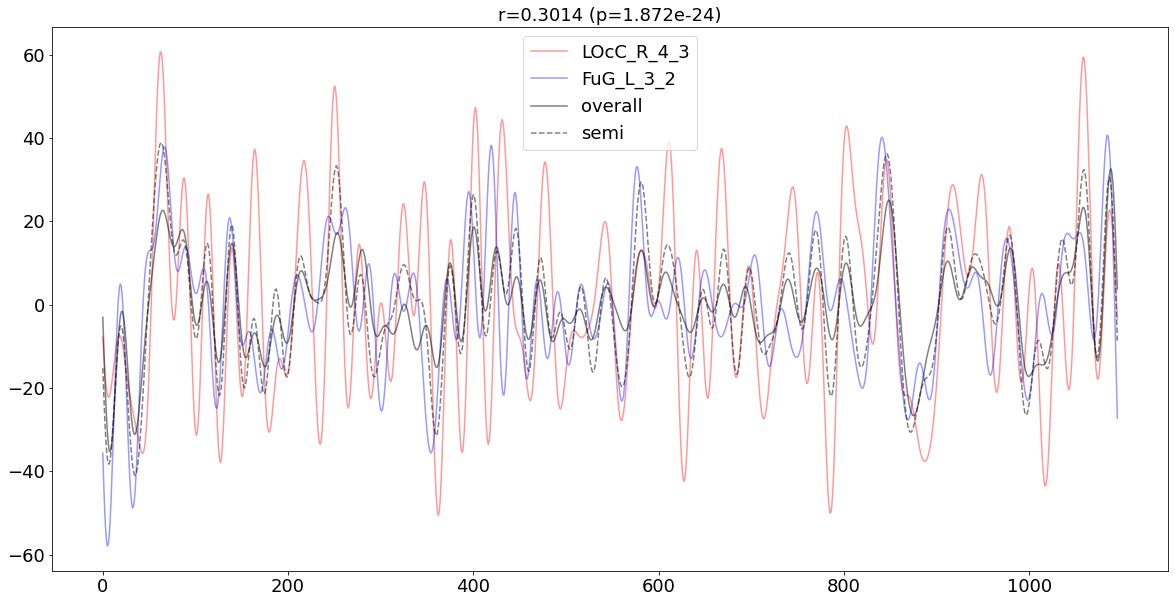

In [21]:
a = 'LOcC_R_4_3'
b = 'FuG_L_3_2'
X = masked_data[a]
Y = masked_data[b]

plt.figure(figsize=(20,10))
plt.plot(np.arange(1096), X, 'r-', label=a, alpha=0.4)
plt.plot(np.arange(1096), Y, 'b-', label=b, alpha=0.4)
plt.plot(np.arange(1096), whole_brain, 'k-', label='overall', alpha=0.5)
plt.plot(np.arange(1096), semi_whole_brain, 'k--', label='semi', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('r=%.4f (p=%.3e)' % (*scipy.stats.pearsonr(x=X, y=Y),), fontsize=18)

Text(0.5, 1.0, 'r=-0.2998 (p=3.371e-24)')

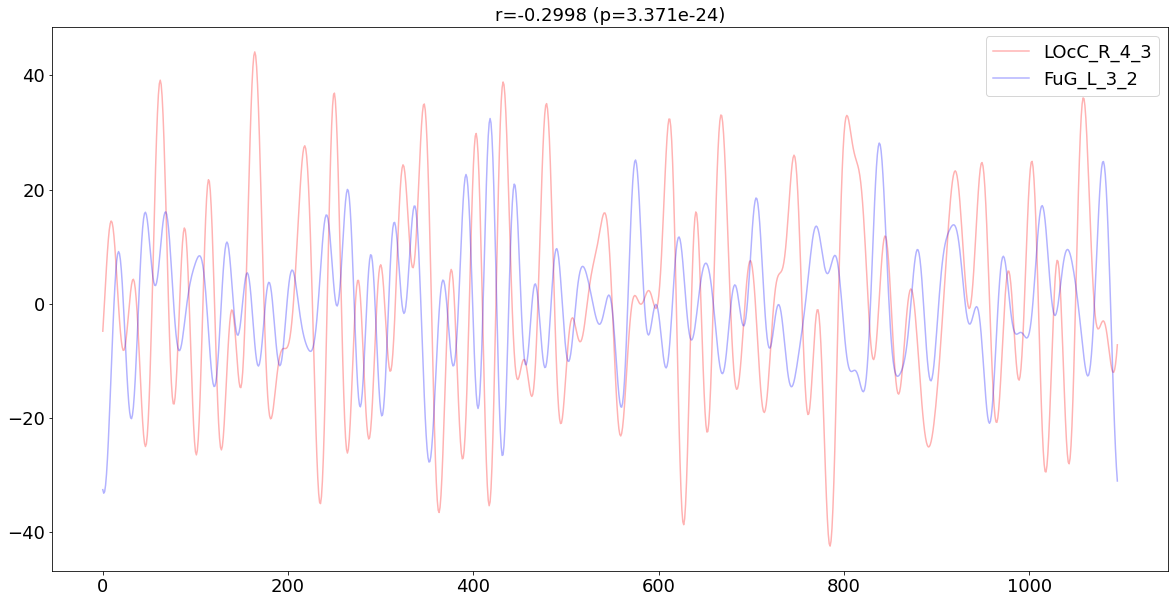

In [22]:
## variation from whole brain
X = masked_data[a]-whole_brain
Y = masked_data[b]-whole_brain

plt.figure(figsize=(20,10))
plt.plot(np.arange(1096), X, 'r-', label=a, alpha=0.3)
plt.plot(np.arange(1096), Y, 'b-', label=b, alpha=0.3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('r=%.4f (p=%.3e)' % (*scipy.stats.pearsonr(x=X, y=Y),), fontsize=18)

Text(0.5, 1.0, 'r=-0.6045 (p=3.638e-110)')

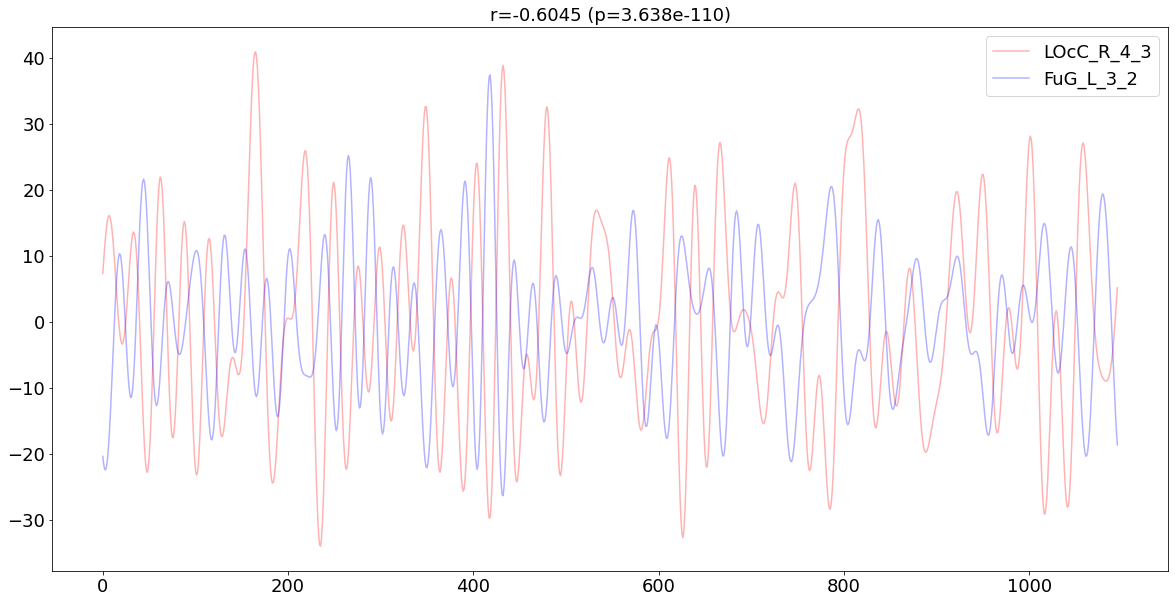

In [24]:
## variation from semi-whole brain
X = masked_data[a]-semi_whole_brain
Y = masked_data[b]-semi_whole_brain

plt.figure(figsize=(20,10))
plt.plot(np.arange(1096), X, 'r-', label=a, alpha=0.3)
plt.plot(np.arange(1096), Y, 'b-', label=b, alpha=0.3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('r=%.4f (p=%.3e)' % (*scipy.stats.pearsonr(x=X, y=Y),), fontsize=18)